# 사용자 기반 협업 필터링

사용자들의 관심사를 토대로 어떤 사용자에게 새로운 관심사를 추천하는 방법에 대해 살펴봅니다.

In [1]:
import math
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

## 사용자들의 관심사 데이터

사용자들의 관심사를 2차원 배열로 저장합니다. user_interests[i]는 i번째 사용자의 관심사 목록을 나타냅니다.

In [2]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

## 사용자들 간의 유사도 계산

### 유사도 정의

사용자들 간의 유사도를 정의합니다. v와 w는 두 사용자 각각의 관심사 벡터이고 두 벡터 사이의 각도가 0도에 가까울수록 유사한 관심사를 가지고 있다고 간주합니다.

In [3]:
def cosine_similarity(v, w):
    return np.dot(v, w) / math.sqrt(np.dot(v, v) * np.dot(w, w))

### 관심사 벡터 만들기

각각의 관심사에 인덱스를 부여합니다.

In [4]:
unique_interests = sorted(list({ interest for user_interests in users_interests for interest in user_interests }))
print(unique_interests)

['Big Data', 'C++', 'Cassandra', 'HBase', 'Hadoop', 'Haskell', 'Java', 'Mahout', 'MapReduce', 'MongoDB', 'MySQL', 'NoSQL', 'Postgres', 'Python', 'R', 'Spark', 'Storm', 'artificial intelligence', 'databases', 'decision trees', 'deep learning', 'libsvm', 'machine learning', 'mathematics', 'neural networks', 'numpy', 'pandas', 'probability', 'programming languages', 'regression', 'scikit-learn', 'scipy', 'statistics', 'statsmodels', 'support vector machines', 'theory']


각 사용자의 관심사 벡터를 만듭니다.

In [5]:
def make_user_interest_vector(user_interests):
    return [1 if interest in user_interests else 0 for interest in unique_interests]

사용자들의 관심사를 행렬로 만듭니다.

In [6]:
user_interest_matrix = list(map(make_user_interest_vector, users_interests))
print(user_interest_matrix)

[[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0,

### 유사도 계산

사용자들 간의 유사도를 계산합니다.

In [7]:
user_similarities = [[round(cosine_similarity(interest_vector_i, interest_vector_j), 2) for interest_vector_j in user_interest_matrix] for interest_vector_i in user_interest_matrix]
print(user_similarities)

[[1.0, 0.34, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.19, 0.57, 0.0, 0.0, 0.0, 0.17, 0.0], [0.34, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0], [0.0, 0.0, 1.0, 0.18, 0.0, 0.17, 0.0, 0.2, 0.0, 0.0, 0.24, 0.0, 0.47, 0.0, 0.0], [0.0, 0.0, 0.18, 1.0, 0.22, 0.37, 0.45, 0.0, 0.0, 0.0, 0.52, 0.22, 0.52, 0.0, 0.26], [0.0, 0.0, 0.0, 0.22, 1.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58], [0.15, 0.0, 0.17, 0.37, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2, 0.24, 0.2, 0.47, 0.0, 0.0], [0.0, 0.0, 0.0, 0.45, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.29, 0.25, 0.0, 0.0, 0.0], [0.0, 0.0, 0.2, 0.0, 0.25, 0.0, 0.0, 1.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 0.25, 0.0, 0.5, 0.0, 0.0, 0.0], [0.57, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.25, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.24, 0.52, 0.0, 0.24, 0.29, 0.0, 0.0, 0.0, 1.0, 0.0, 0.33, 0.0, 0.0], [0.0, 0.0, 0.0, 0.22, 0.0, 0.2, 0.25, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.47, 0.52, 0.0, 0.47

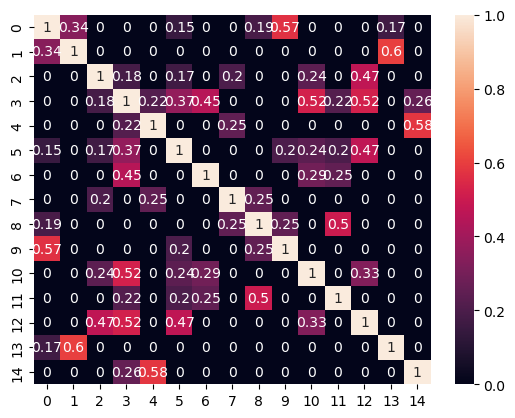

In [8]:
hm = sns.heatmap(data = user_similarities, annot=True)
plt.show()

## 관심사 추천

### 유사한 사용자 찾기

한 사용자와의 유사도가 0보다 큰 사용자들을 찾아서 유사도가 큰 순서대로 나열합니다.

In [9]:
def most_similar_users_to(user_id):
    pairs = [(other_user_id, similarity) for other_user_id, similarity in enumerate(user_similarities[user_id]) if user_id != other_user_id and similarity > 0]
    
    return sorted(pairs, key=lambda x : x[1], reverse=True)

most_similar_users = most_similar_users_to(0)
print(most_similar_users)

[(9, 0.57), (1, 0.34), (8, 0.19), (13, 0.17), (5, 0.15)]


위에서 찾은 사용자들의 관심사를 시각적으로 비교하기 위하여 이들의 관심사 벡터를 하나의 열 지도 형식으로 표현합니다.

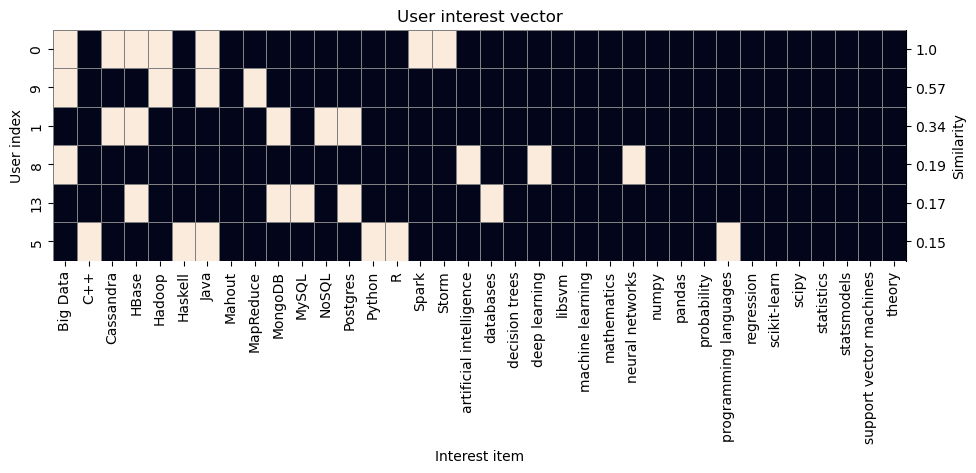

In [10]:
similar_user_interest_matrix = [user_interest_matrix[other_user_id] for other_user_id, _ in most_similar_users]
similar_user_interest_matrix.insert(0, user_interest_matrix[0])

user_id_list = [other_user_id for other_user_id, _ in most_similar_users]
user_id_list.insert(0, 0)

similarity_list = [similarity for _, similarity in most_similar_users]
similarity_list.insert(0, 1.0)

plt.figure(figsize=(11, 3))
ax = plt.axes()

hm = sns.heatmap(data = similar_user_interest_matrix, annot=False, cbar=False, linewidths=0.5, linecolor="grey")

ax.set_xticklabels(unique_interests, rotation=90)
ax.set_yticklabels(user_id_list)
ax.set_xlabel("Interest item")
ax.set_ylabel("User index")

secondary_ax = ax.secondary_yaxis('right')
secondary_ax.set_yticks(ax.get_yticks().tolist())
secondary_ax.set_yticklabels(similarity_list)
secondary_ax.set_ylabel('Similarity')

plt.title("User interest vector")

plt.show()

### 추천 항목 찾기

사용자들의 유사도를 활용하여 추천 항목을 고르는 방법에는 여러 가지가 있을 수 있습니다. 예를 들자면 아래와 같습니다.

1. 가장 유사한 사람의 관심 항목들을 추천
2. 유사도가 높은 사람의 관심 항목들에는 높은 가중치를 부여하고 유사도가 낮은 사람의 관심 항목들에는 낮은 가중치를 부여하는 방식으로 점수를 매기고 더해서 가장 높은 점수를 받은 항목들을 우선적으로 추천

여기서는 2번 방식으로 추천 항목들을 찾아봅니다. 이러한 방식은 유사도가 높은 사람의 관심사뿐만 아니라 유사도가 낮은 사람의 관심사도 적절히 반영하는 것이므로 협업 필터링의 취지에 잘 부합한다고 말할 수 있습니다.

이해를 돕기 위하여 유사한 사용자들의 관심사 벡터에 가중치를 적용하면 다음과 같은 열 지도를 얻을 수 있습니다.

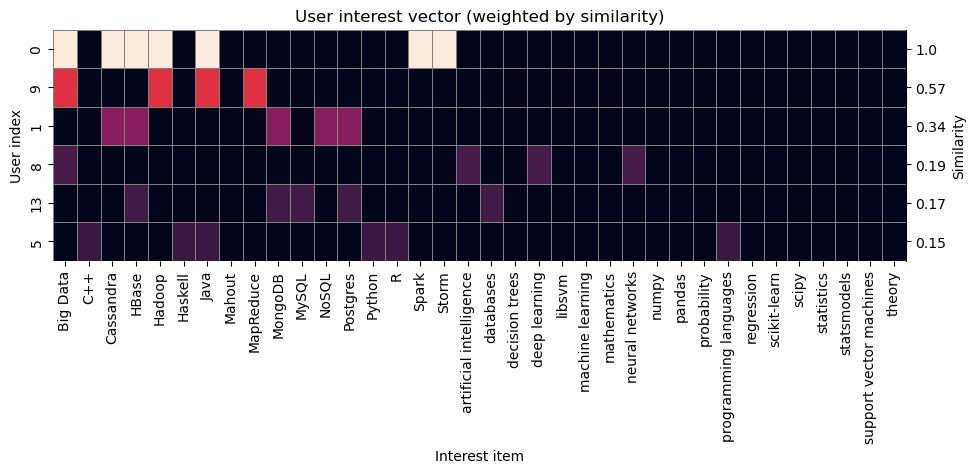

In [11]:
similar_user_interest_matrix_weighted = [[interest * similarity_list[other_user_id] for interest in user_interest_vector] for other_user_id, user_interest_vector in enumerate(similar_user_interest_matrix)]

plt.figure(figsize=(11, 3))
ax = plt.axes()

hm = sns.heatmap(data = similar_user_interest_matrix_weighted, annot=False, cbar=False, linewidths=0.5, linecolor="grey")

ax.set_xticklabels(unique_interests, rotation=90)
ax.set_yticklabels(user_id_list)
ax.set_xlabel("Interest item")
ax.set_ylabel("User index")

secondary_ax = ax.secondary_yaxis('right')
secondary_ax.set_yticks(ax.get_yticks().tolist())
secondary_ax.set_yticklabels(similarity_list)
secondary_ax.set_ylabel('Similarity')

plt.title("User interest vector (weighted by similarity)")

plt.show()

각각의 관심 항목에 대하여 유사한 사용자들의 유사도를 가중치로 적용하여 더한 값을 점수로 간주합니다. 그리고 점수가 높은 순으로 나열하여 추천합니다.

In [12]:
def user_based_suggestions(user_id, include_current_interests=False):
    suggestions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity
            
    suggestions = sorted(suggestions.items(), key=lambda x : x[1], reverse=True)
    
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight) for suggestion, weight in suggestions if suggestion not in users_interests[user_id]]

In [13]:
suggestions = user_based_suggestions(0)
print(suggestions)

[('MapReduce', 0.57), ('MongoDB', 0.51), ('Postgres', 0.51), ('NoSQL', 0.34), ('neural networks', 0.19), ('deep learning', 0.19), ('artificial intelligence', 0.19), ('databases', 0.17), ('MySQL', 0.17), ('Python', 0.15), ('R', 0.15), ('C++', 0.15), ('Haskell', 0.15), ('programming languages', 0.15)]


추천 항목과 점수를 관심사 벡터의 열 지도와 비교하기 쉽도록 막대 그래프로 표현하면 다음과 같습니다.

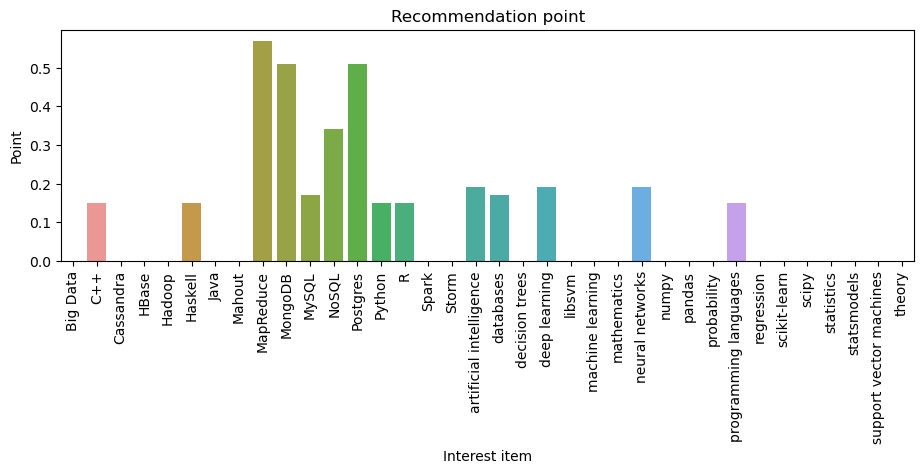

In [20]:
points = []
for interest in unique_interests:
    point = 0
    for suggestion in suggestions:
        if suggestion[0] == interest:
            point += suggestion[1]
    points.append(point)

plt.figure(figsize=(11, 3))
ax = plt.axes()

sns.barplot(x=unique_interests, y=points)

ax.set_xticklabels(unique_interests, rotation=90)
ax.set_xlabel("Interest item")
ax.set_ylabel("Point")

plt.title("Recommendation point")

plt.show()

## 정리

* 관심 항목 개수가 적을 때 유용한 방식입니다.